In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from aiutils import load

In [30]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
# project_root = '/home/justiny/Princeton/PyDominion'
model_dir = os.path.join(project_root, 'models')
fig_dir = '/home/justiny/Documents/Projects/Thesis/dominion-thesis/figures'

In [11]:
idx = pd.IndexSlice

In [ ]:
# Multi-index of first card buy
def first_card_idxs(df, card):
    temp = df[df['Card'] == card][['Iter', 'Turn']].groupby('Iter').min()
    return temp.reset_index().set_index(['Iter', 'Turn']).index

In [16]:
df = sim_stats.turn_df
df['Count'] = df.groupby(['Iter', 'Player', 'Card']).cumcount() + 1

player_df = sim_stats.player_df

game_df = sim_stats.game_df

n = len(game_df)

p0_df, p1_df = df[df['Player']==0], df[df['Player']==1]
p0_game_df, p1_game_df = player_df[player_df['Player']==0].reset_index(drop=True), player_df[player_df['Player']==1].reset_index(drop=True)

In [17]:
# Indices of pure win/loss/tie games
p_win_idxs = p0_game_df[(p0_game_df['Won'] == True) & (game_df['Tie'] == False)].index
p_loss_idxs = p0_game_df[(p0_game_df['Won'] == False) & (game_df['Tie'] == False)].index
tie_idxs = p0_game_df[game_df['Tie'] == True].index

assert len(p_win_idxs) + len(p_loss_idxs) + len(tie_idxs) == n

# Indices of win (pure win + tie) / loss (pure loss + tie) games
win_idxs = p_win_idxs.union(tie_idxs)
loss_idxs = p_loss_idxs.union(tie_idxs)

assert len(p_win_idxs) + len(loss_idxs) == n

# Indices of games where starting player gets extra turn or not
eq_turn_idxs = p0_game_df[p0_game_df['Turns'] == p1_game_df['Turns']].index 
neq_turn_idxs = p0_game_df[p0_game_df['Turns'] == p1_game_df['Turns'] + 1].index 

assert len(eq_turn_idxs) + len(neq_turn_idxs) == n

tie_loss_idxs = neq_turn_idxs.intersection(tie_idxs)
fair_loss_idxs = p_loss_idxs.union(tie_loss_idxs)

# Multi-index of last turn in each game
last_turn_idxs_df = (p0_df[['Iter', 'Turn']].groupby('Iter').max())['Turn']
last_turn_idxs = list(zip(last_turn_idxs_df.index, last_turn_idxs_df))

# Multi-index of penultimate turn in each game
penult_turn_idxs_df = (p0_df[['Iter', 'Turn']].groupby('Iter').max() - 1)['Turn']
penult_turn_idxs = list(zip(penult_turn_idxs_df.index, penult_turn_idxs_df))

# Indices of non-upper-tail games
non_utail_idxs = game_df[game_df['Turns'] <= 20].index

## Symmetric DoubleWitch Starting Advantage ##

In [13]:
dataset_name = 'dw25-dw25-10k-stats'
data_path = os.path.join(project_root, 'data', dataset_name)
sim_stats = load(data_path)

In [26]:
action_df = sim_stats.action_df

curse_turns = action_df[['Iter', 'Player', 'Turn']].groupby('Iter').head(10)
witch_turns = action_df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).count()

p0_curse_turns = curse_turns[curse_turns['Player'] == 0]
p1_curse_turns = curse_turns[curse_turns['Player'] == 1]
p0_witch_turns = witch_turns.loc[idx[:, 0], :].reset_index().set_index('Iter')
p1_witch_turns = witch_turns.loc[idx[:, 1], :].reset_index().set_index('Iter')

### Posteriors ###

In [27]:
temp = p0_witch_turns['Turn'] > p1_witch_turns['Turn']
p0_more_witch_idxs = temp[temp == True].index

temp = p0_witch_turns['Turn'] < p1_witch_turns['Turn']
p0_fewer_witch_idxs = temp[temp == True].index

temp = p0_witch_turns['Turn'] == p1_witch_turns['Turn']
p0_eq_witch_idxs = temp[temp == True].index

n_prior = len(p0_more_witch_idxs)
n_wins = len(p0_more_witch_idxs.intersection(p_win_idxs))
n_loss = len(p0_more_witch_idxs.intersection(p_loss_idxs))
print(f'Prior: {n_prior / n * 100:.2f}%')
print(f'P(Win | more Witch turns) = {n_wins / n_prior * 100:.2f}%')
print(f'P(Loss | more Witch turns) = {n_loss / n_prior* 100:.2f}%')
print(f'P(Tie | more Witch turns) = {(n_prior - n_wins - n_loss) / n_prior* 100:.2f}%\n')

n_prior = len(p0_fewer_witch_idxs)
n_wins = len(p0_fewer_witch_idxs.intersection(p_win_idxs))
n_loss = len(p0_fewer_witch_idxs.intersection(p_loss_idxs))
print(f'Prior: {n_prior / n * 100:.2f}%')
print(f'P(Win | fewer Witch turns) = {n_wins / n_prior* 100:.2f}%')
print(f'P(Loss | fewer Witch turns) = {n_loss / n_prior* 100:.2f}%')
print(f'P(Tie | fewer Witch turns) = {(n_prior - n_wins - n_loss) / n_prior* 100:.2f}%\n')

n_prior = len(p0_eq_witch_idxs)
n_wins = len(p0_eq_witch_idxs.intersection(p_win_idxs))
n_loss = len(p0_eq_witch_idxs.intersection(p_loss_idxs))
print(f'Prior: {n_prior / n * 100:.2f}%')
print(f'P(Win | eq Witch turns) = {n_wins / n_prior* 100:.2f}%')
print(f'P(Loss | eq Witch turns) = {n_loss / n_prior* 100:.2f}%')
print(f'P(Tie | eq Witch turns) = {(n_prior - n_wins - n_loss) / n_prior* 100:.2f}%')

Prior: 46.96%
P(Win | more Witch turns) = 80.37%
P(Loss | more Witch turns) = 17.12%
P(Tie | more Witch turns) = 2.51%

Prior: 36.51%
P(Win | fewer Witch turns) = 28.57%
P(Loss | fewer Witch turns) = 67.65%
P(Tie | fewer Witch turns) = 3.78%

Prior: 16.53%
P(Win | eq Witch turns) = 53.30%
P(Loss | eq Witch turns) = 40.77%
P(Tie | eq Witch turns) = 5.93%


### Trajectories ###

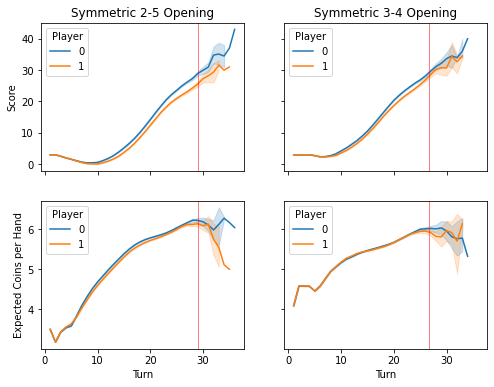

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex='all', sharey='row')

sns.lineplot(x='Turn', y='Score', data=dw25_turns, hue='Player', ax=axes[0, 0])
axes[0, 0].set_title(f'Symmetric 2-5 Opening')
axes[0, 0].axvline(x=mu_25_turns + 2 * sigma_25_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Score', data=dw34_turns, hue='Player', ax=axes[0, 1])
axes[0, 1].set_title(f'Symmetric 3-4 Opening')
axes[0, 1].axvline(x=mu_34_turns + 2 * sigma_34_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=dw25_turns, hue='Player', ax=axes[1,0])
axes[1, 0].axvline(x=mu_25_turns + 2 * sigma_25_turns, c='r', linewidth=0.5)
sns.lineplot(x='Turn', y='Density', data=dw34_turns, hue='Player', ax=axes[1,1])
axes[1, 1].axvline(x=mu_34_turns + 2 * sigma_34_turns, c='r', linewidth=0.5)
axes[1, 0].set_ylabel(f'Expected Coins per Hand')
plt.show()

In [ ]:
fig.savefig(os.path.join(fig_dir, 'dw-starting-advantage.png'), dpi=600)

### First Witch play turn and Curse count difference ###

In [20]:
dw25_stats = load(os.path.join(project_root, 'data', 'dw25-dw25-10k-stats'))
dw34_stats = load(os.path.join(project_root, 'data', 'dw34-dw34-10k-stats'))

dw25_turns = dw25_stats.turn_df
dw34_turns = dw34_stats.turn_df
dw25_game = dw25_stats.game_df
dw34_game = dw34_stats.game_df
dw25_actions = dw25_stats.action_df
dw34_actions = dw34_stats.action_df 

dw25_turns['Count'] = dw25_turns.groupby(['Iter','Player','Card']).cumcount() + 1
dw34_turns['Count'] = dw34_turns.groupby(['Iter', 'Player', 'Card']).cumcount() + 1

mu_25_turns = dw25_game['Turns'].mean()
sigma_25_turns = dw25_game['Turns'].std()
mu_34_turns = dw34_game['Turns'].mean()
sigma_34_turns = dw34_game['Turns'].std()

dw25_first_witch_turn = dw25_stats.action_df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).min()
dw34_first_witch_turn = dw34_stats.action_df[['Iter', 'Player', 'Turn']].groupby(['Iter', 'Player']).min()

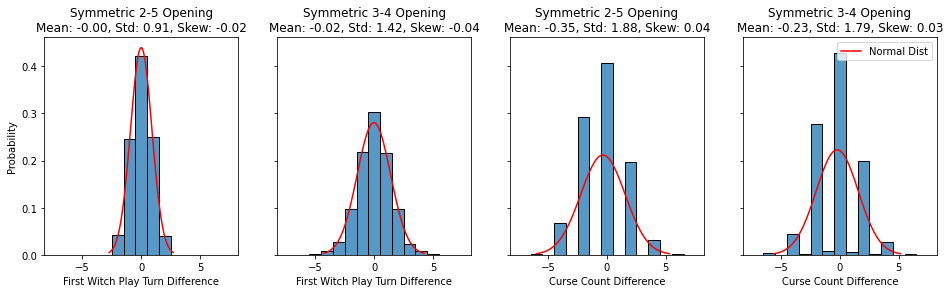

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex='all', sharey='all')

p0_dw25_first_witch_turn = dw25_first_witch_turn.loc[idx[:, 0], :].reset_index()
p1_dw25_first_witch_turn = dw25_first_witch_turn.loc[idx[:, 1], :].reset_index()

p0_dw34_first_witch_turn = dw34_first_witch_turn.loc[idx[:, 0], :].reset_index()
p1_dw34_first_witch_turn = dw34_first_witch_turn.loc[idx[:, 1], :].reset_index()

dw25_curse_turns = dw25_actions[['Iter', 'Player', 'Turn']].groupby('Iter').head(10)
dw25_p0_curse_turns = dw25_curse_turns[dw25_curse_turns['Player'] == 0]
dw25_p1_curse_turns = dw25_curse_turns[dw25_curse_turns['Player'] == 1]
dw25_p1_curse_counts = dw25_p0_curse_turns[['Iter', 'Turn']].groupby('Iter').count()
dw25_p0_curse_counts = dw25_p1_curse_turns[['Iter', 'Turn']].groupby('Iter').count()

dw34_curse_turns = dw34_actions[['Iter', 'Player', 'Turn']].groupby('Iter').head(10)
dw34_p0_curse_turns = dw34_curse_turns[dw34_curse_turns['Player'] == 0]
dw34_p1_curse_turns = dw34_curse_turns[dw34_curse_turns['Player'] == 1]
dw34_p1_curse_counts = dw34_p0_curse_turns[['Iter', 'Turn']].groupby('Iter').count()
dw34_p0_curse_counts = dw34_p1_curse_turns[['Iter', 'Turn']].groupby('Iter').count()

data = p0_dw25_first_witch_turn['Turn'] - p1_dw25_first_witch_turn['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r')
axes[0].set_title(f'Symmetric 2-5 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[0].set_xlabel(f'First Witch Play Turn Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[0])

data = p0_dw34_first_witch_turn['Turn'] - p1_dw34_first_witch_turn['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r')
axes[1].set_title(f'Symmetric 3-4 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[1].set_xlabel(f'First Witch Play Turn Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[1])

data = dw25_p0_curse_counts['Turn'] - dw25_p1_curse_counts['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[2].plot(x, stats.norm.pdf(x, mu, sigma), 'r')
axes[2].set_title(f'Symmetric 2-5 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[2].set_xlabel(f'Curse Count Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[2])

data = dw34_p0_curse_counts['Turn'] - dw34_p1_curse_counts['Turn']
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
normal_dist, = axes[3].plot(x, stats.norm.pdf(x, mu, sigma), 'r')
axes[3].set_title(f'Symmetric 3-4 Opening\nMean: {mu:.2f}, Std: {sigma:.2f}, Skew: {skew:.2f}')
axes[3].legend((normal_dist,), ('Normal Dist',))
axes[3].set_xlabel(f'Curse Count Difference')
sns.histplot(data=data, stat='probability', discrete=True, ax=axes[3])
plt.show()

In [24]:
fig.savefig(os.path.join(fig_dir, 'dw-symmetric-turn-diff-curse-count.png'), dpi=600)

### Extra Turn Posteriors ###

In [31]:
print('All following probabilities refer to starting player.')

n_extra_turn = len(neq_turn_idxs)
n_ties = len(tie_idxs)
n_wins = len(p_win_idxs)
print(f'P(Win) = {(n_wins / n) * 100:.2f}%')
print(f'P(Loss) = {(n - n_wins - n_ties) / n * 100:.2f}%')
print(f'P(Tie) = {n_ties / n * 100:.2f}%\n')

print(f'Starting player gets extra turn (i.e. ends game) {n_extra_turn / n * 100}% of the time.')

p0_win_given_extra_turn = len(p_win_idxs.intersection(neq_turn_idxs))
p0_loss_given_extra_turn = len(p_loss_idxs.intersection(neq_turn_idxs))
p0_tie_given_extra_turn = len(tie_idxs.intersection(neq_turn_idxs))
print(f'P(Wins | Extra Turn) = {p0_win_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Loses | Extra Turn) = {p0_loss_given_extra_turn / n_extra_turn * 100:.2f}%')
print(f'P(Ties | Extra Turn) = {p0_tie_given_extra_turn / n_extra_turn * 100:.2f}%')

print('')
n_eq_turn = len(eq_turn_idxs)
p0_win_equal_turn = len(p_win_idxs.intersection(eq_turn_idxs))
p0_loss_equal_turn = len(p_loss_idxs.intersection(eq_turn_idxs))
p0_tie_equal_turn = len(tie_idxs.intersection(eq_turn_idxs))
print(f'P(Wins | Equal Turn) = {p0_win_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Loses | Equal Turn) = {p0_loss_equal_turn / n_eq_turn * 100:.2f}%')
print(f'P(Ties | Equal Turn) = {p0_tie_equal_turn / n_eq_turn * 100:.2f}%')

All following probabilities refer to starting player.
P(Win) = 56.98%
P(Loss) = 39.48%
P(Tie) = 3.54%

Starting player gets extra turn (i.e. ends game) 50.5% of the time.
P(Wins | Extra Turn) = 67.50%
P(Loses | Extra Turn) = 32.50%
P(Ties | Extra Turn) = 0.00%

P(Wins | Equal Turn) = 46.24%
P(Loses | Equal Turn) = 46.61%
P(Ties | Equal Turn) = 7.15%


### Card Count Evolution ###

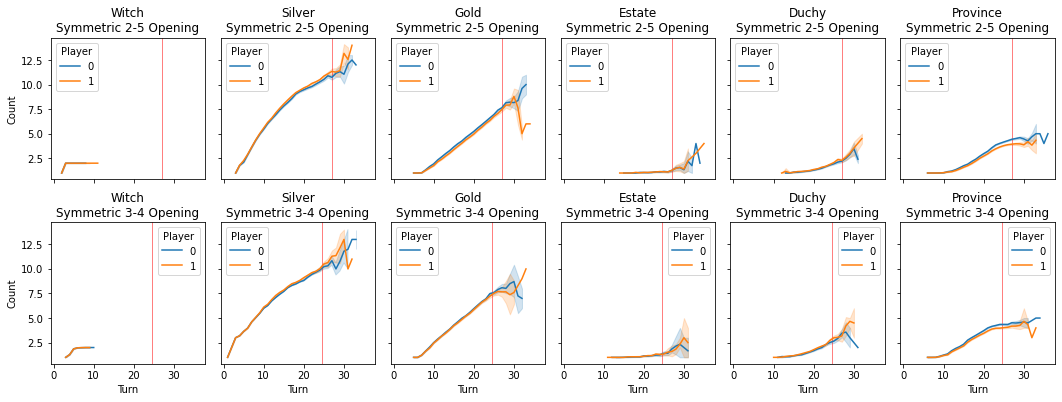

In [48]:
cards = ['Witch', 'Silver', 'Gold', 'Estate', 'Duchy', 'Province']
fig, axes = plt.subplots(2, len(cards), figsize=(18, 6), sharex='all', sharey='all')

dw25_mu_turns = dw25_game['Turns'].mean()
dw25_sigma_turns = dw25_game['Turns'].std()

dw34_mu_turns = dw34_game['Turns'].mean()
dw34_sigma_turns = dw34_game['Turns'].std()

for i, card in enumerate(cards):
    df_select = dw25_turns[dw25_turns['Card'] == card]    
    axes[0,i].set_title(f'{card}\nSymmetric 2-5 Opening')
    axes[0,i].axvline(x=dw25_mu_turns + dw25_sigma_turns, c='r', linewidth=0.5)
    sns.lineplot(x='Turn', y='Count', data=df_select, hue='Player', ax=axes[0,i])  

    df_select = dw34_turns[dw34_turns['Card'] == card]    
    axes[1,i].set_title(f'{card}\nSymmetric 3-4 Opening')
    axes[1,i].axvline(x=dw34_mu_turns + dw34_sigma_turns, c='r', linewidth=0.5)
    sns.lineplot(x='Turn', y='Count', data=df_select, hue='Player', ax=axes[1,i])  
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [49]:
fig.savefig(os.path.join(fig_dir, 'symmetric-dw-card-counts.png'), dpi=600)